<a href="https://colab.research.google.com/github/MovinduSenura/Chest-Xray-Pneumonia-Detection/blob/dev-senura/notebooks/CustomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTS

import os
import sys
import importlib
from datetime import datetime
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from PIL import ImageFile

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from google.colab import drive

In [2]:
# FIX TRUNCATED/CORRUPTED IMAGES

ImageFile.LOAD_TRUNCATED_IMAGES = True

# CLONE GITHUB REPOSITORY

if not os.path.exists('Chest-Xray-Pneumonia-Detection'):
    !git clone https://github.com/MovinduSenura/Chest-Xray-Pneumonia-Detection.git

# ADD NOTEBOOKS FOLDER TO PYTHON PATH

sys.path.append('/content/Chest-Xray-Pneumonia-Detection/notebooks/')

# IMPORT PREPROCESSING MODULE

import preprocessing
importlib.reload(preprocessing)
from preprocessing import create_generators

# MOUNT GOOGLE DRIVE

drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/DL_Assignment/chest_xray/'

Cloning into 'Chest-Xray-Pneumonia-Detection'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 261 (delta 17), reused 7 (delta 7), pack-reused 224 (from 2)
Receiving objects: 100% (261/261), 1.10 MiB | 11.07 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Mounted at /content/drive


In [3]:
# PREPARE VALIDATION SPLIT & CREATE GENERATORS

# prepare_validation_split(DATA_DIR)
# train_gen, val_gen, test_gen = create_generators(DATA_DIR)
# print("✅ Data generators created successfully!\n")

# USE EXISTING VAL_FIXED AND CREATE GENERATORS

train_gen, val_gen, test_gen = create_generators(DATA_DIR)
print("✅ Data generators loaded successfully (using existing val_fixed)!\n")

# COMPUTE CLASS WEIGHTS

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Found 5216 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
✅ Data generators loaded successfully (using existing val_fixed)!

Class Weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [4]:
# BUILD CUSTOM CNN MODEL

model = Sequential([
    # Conv Block 1
    Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005), input_shape=(128,128,3)),
    BatchNormalization(),
    Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Conv Block 2
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Conv Block 3
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully Connected
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','Precision','Recall'])
model.summary()

# DEFINE CALLBACKS

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/DL_Assignment/Results6/best_model_cpu.keras',
                    monitor='val_accuracy', save_best_only=True, verbose=1)
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 89,617 (350.07 KB)

 Trainable params: 89,169 (348.32 KB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
# TRAIN MODEL

print("\n🚀 Starting optimized CPU training...\n")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


🚀 Starting optimized CPU training...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Precision: 0.9082 - Recall: 0.7086 - accuracy: 0.7367 - loss: 0.6805
Epoch 1: val_accuracy improved from -inf to 0.74297, saving model to /content/drive/MyDrive/DL_Assignment/Results6/best_model_cpu.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 1063s 3s/step - Precision: 0.9083 - Recall: 0.7088 - accuracy: 0.7369 - loss: 0.6802 - val_Precision: 0.7430 - val_Recall: 1.0000 - val_accuracy: 0.7430 - val_loss: 1.7006 - learning_rate: 5.0000e-04
Epoch 2/25
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.9714 - Recall: 0.8170 - accuracy: 0.8454 - loss: 0.4819
Epoch 2: val_accuracy improved from 0.74297 to 0.84783, saving model to /content/drive/MyDrive/DL_Assignment/Results6/best_model_cpu.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - Precision: 0.9714 - Recall: 0.8170 - accuracy: 0.8454 - loss: 0.4818 - val_Precision: 0.8377 - val_Recall: 0.9862 - val_accuracy: 0.8478 - val_loss: 0.4162 - learning_rate: 5.0000e-04
Epoch 3/25
326/326 ━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



✅ Validation Accuracy: 0.9425
✅ Test Accuracy: 0.8574


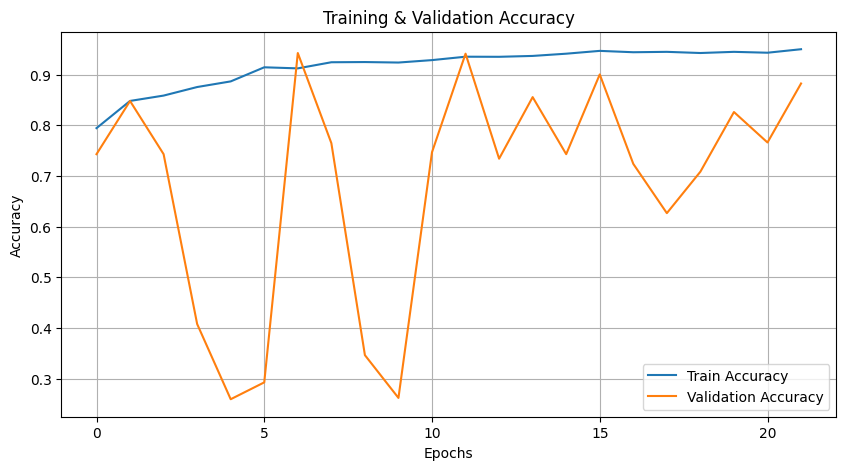

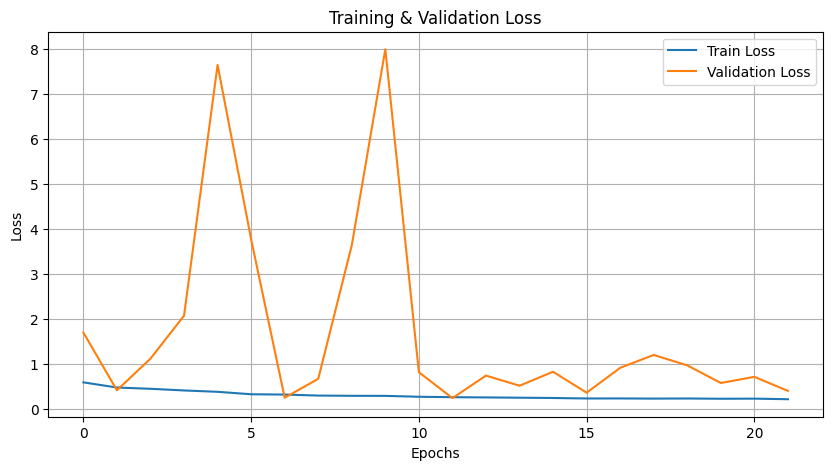

39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 385ms/step


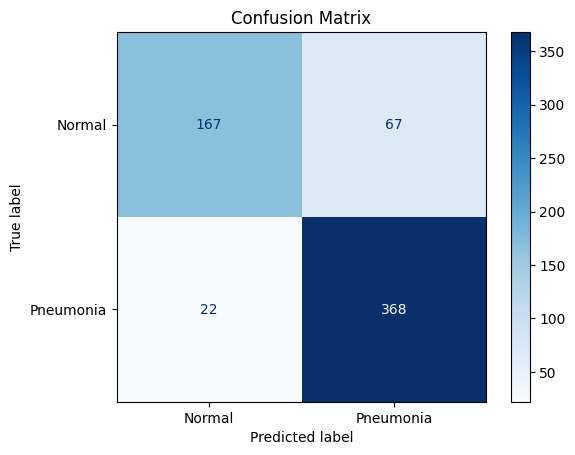

Precision: 0.8601, Recall: 0.8574, F1-Score: 0.8537


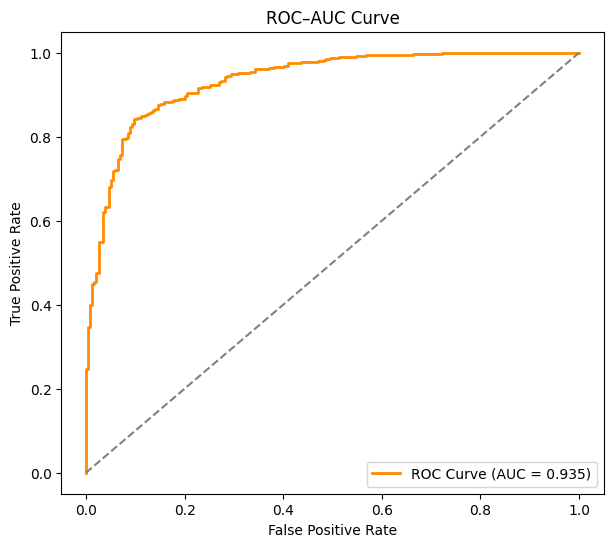

In [7]:
# EVALUATION, VISUALIZATION, AND RESULT SAVING

# Load best model for evaluation
best_model = load_model('/content/drive/MyDrive/DL_Assignment/Results6/best_model_cpu.keras')

# Evaluate on validation and test sets
# The evaluate method returns loss and all metrics specified during compilation.
# In this case, it returns loss, accuracy, Precision, and Recall.
val_loss, val_acc, val_precision, val_recall = best_model.evaluate(val_gen, verbose=0)
test_loss, test_acc, test_precision, test_recall = best_model.evaluate(test_gen, verbose=0)


print(f"\n✅ Validation Accuracy: {val_acc:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Visualization - Accuracy and Loss Curves
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()

# Confusion Matrix and Classification Report
y_true = test_gen.classes
y_pred = best_model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues'); plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia'], output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# ROC–AUC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC–AUC Curve')
plt.legend(); plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 377ms/step


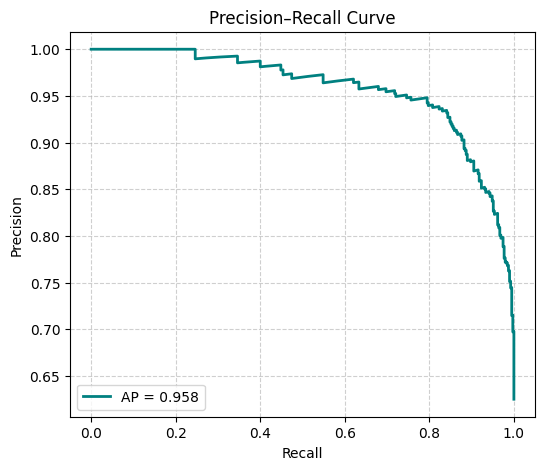

In [14]:
#Precision–Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_proba = best_model.predict(test_gen).ravel()
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='teal', lw=2, label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [10]:
#Classification Report

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       234
           1       0.85      0.94      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624



/tmp/ipython-input-2642477486.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


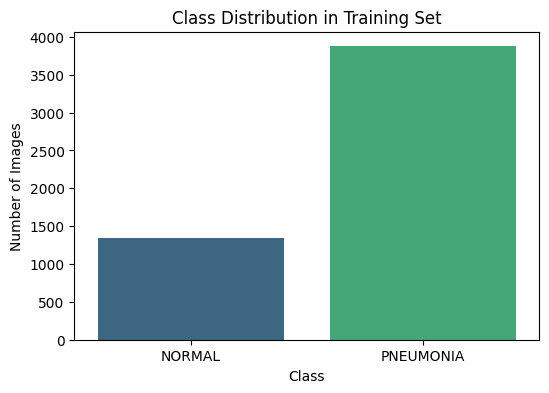

In [11]:
# Extract class indices and labels
labels = list(train_gen.class_indices.keys())

# Get the class names for each image in the training generator
class_names = [labels[i] for i in train_gen.classes]

# Create a DataFrame for easier plotting
df = pd.DataFrame({'Class': class_names})

# Plot using seaborn
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

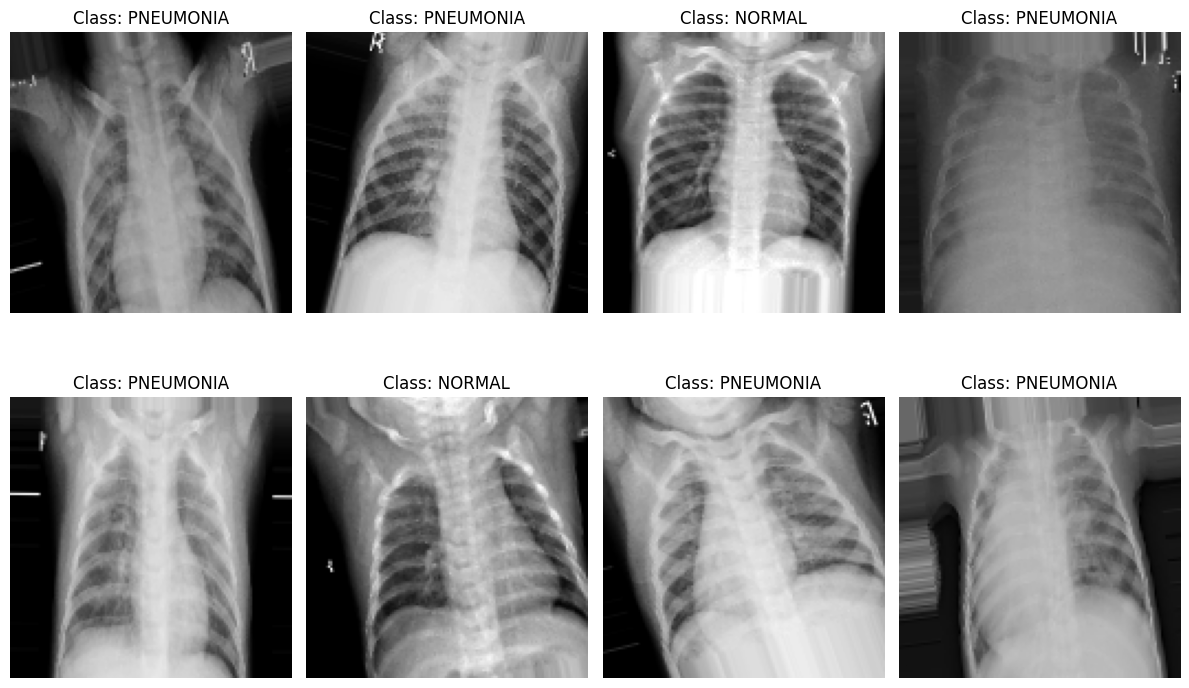

In [12]:
#Dataset Visualization

# Get one batch of images and labels
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(12,8))
for i in range(8):  # display first 8 images
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])

    # Since class_mode='binary', y_batch[i] is 0 or 1
    class_label = list(train_gen.class_indices.keys())[int(y_batch[i])]
    plt.title(f"Class: {class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# SAVE MODEL, PLOTS, AND METRICS TO CSV LOG

# Create Result_Final directory
base_dir = '/content/drive/MyDrive/DL_Assignment/Results6/'
os.makedirs(base_dir, exist_ok=True)

# Create timestamped subfolder
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_folder = os.path.join(base_dir, f"run_{timestamp}")
os.makedirs(run_folder, exist_ok=True)

# Save model
model_path = os.path.join(run_folder, "CustomCNN_Optimized.keras")
best_model.save(model_path)

# Save accuracy/loss plots
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')
plt.savefig(os.path.join(run_folder, "accuracy_plot.png")); plt.close()

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.savefig(os.path.join(run_folder, "loss_plot.png")); plt.close()

# Save confusion matrix
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig(os.path.join(run_folder, "confusion_matrix.png"))
plt.close()

# Save ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.legend(); plt.title('ROC–AUC Curve')
plt.savefig(os.path.join(run_folder, "roc_curve.png"))
plt.close()

# Write metrics to CSV
csv_file = os.path.join(base_dir, "final_results_log.csv")
fieldnames = [
    "Timestamp", "Epochs",
    "Train_Accuracy", "Val_Accuracy", "Val_Loss",
    "Best_Val_Accuracy", "Best_Val_Loss",
    "Test_Accuracy", "Test_Loss",
    "Precision", "Recall", "F1_Score", "ROC_AUC",
    "Run_Folder_Path"
]

# Get best metrics from training history
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])

file_exists = os.path.isfile(csv_file)
with open(csv_file, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow({
        "Timestamp": timestamp,
        "Epochs": len(history.history['accuracy']),
        "Train_Accuracy": history.history['accuracy'][-1],
        "Val_Accuracy": val_acc,
        "Val_Loss": val_loss,
        "Best_Val_Accuracy": best_val_acc,
        "Best_Val_Loss": best_val_loss,
        "Test_Accuracy": test_acc,
        "Test_Loss": test_loss,
        "Precision": precision,
        "Recall": recall,
        "F1_Score": f1,
        "ROC_AUC": roc_auc,
        "Run_Folder_Path": run_folder
    })

print(f"\n✅ Final results saved in: {run_folder}")
print(f"📊 Metrics logged in: {csv_file}")


✅ Final results saved in: /content/drive/MyDrive/DL_Assignment/Results6/run_2025-10-11_13-51-01
📊 Metrics logged in: /content/drive/MyDrive/DL_Assignment/Results6/final_results_log.csv
